## TODO:

Structure:
1. Read data
    - <input type="checkbox"></input>display count of rows
    - <input type="checkbox"></input> display columns; give description for each column
    - <input type="checkbox"></input>show how many rows have 1 None value, 2 None, ..., all None values
2. Display each column
    - <input type="checkbox"></input> **title**: min/max/average length, stretch goal: show most popular topics
    - <input type="checkbox"></input>**url**: what site is the most popular
    - <input type="checkbox"></input>**published_date**: min/max range, show distribution per year, maybe per season/year
    - <input type="checkbox"></input>**author**: show how many authors are on average per each article, who is the most popular author
    - <input type="checkbox"></input>**publisher**: check that there is only one publisher
    - <input type="checkbox"></input>**short_description**: check empty values, show that short_description is basically the first sentence of description (but before check this assumption). If it is true then it will be strategy for filling empty values in case description exists
    - <input type="checkbox"></input>**keywords**: how many keywords on average, what is the most popular, what is the list popular
    - <input type="checkbox"></input>**header_image**: check that all images are located on cnbc website
    - <input type="checkbox"></input>**raw_description**: is the same as description only with html tags. In case raw description exists but not description, raw description can be used as description but only after stripping all html tags
    - <input type="checkbox"></input>**description**: min/average/max. Show number of empty values. Check that when description is empty raw_description is not. Stretch goal: most popular topics
    - <input type="checkbox"></input>**scraped_at**: skip? maybe show the range


# TODO:

1. <input type="checkbox"></input>Title: check encoding

<h1><center>Exploratory Data Analysis</center></h1>

In [1]:
cd ..

/Users/andreiaksionov/Study/Machine_Learning/semantic_search/Weaviate-demo


In [323]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from omegaconf import OmegaConf

pd.set_option("display.max_colwidth", 100)

# ROOT = os.path.realpath("../")
# if ROOT not in sys.path:
#     sys.path.append(ROOT)

from src import config


# 1. Read data

Read file from csv format and display the first article.

In [3]:
data = pd.read_csv(config.data.raw)
data.head(1)

,title,url,published_at,author,publisher,short_description,keywords,header_image,raw_description,description,scraped_at
0,Santoli’s Wednesday market notes: Could September’s stock shakeout tee up strength for the fourt...,https://www.cnbc.com/2021/09/29/santolis-wednesday-market-notes-could-septembers-stock-shakeout-...,2021-09-29T17:09:39+0000,Michael Santoli,CNBC,"This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...","cnbc, Premium, Articles, Investment strategy, Markets, Investing, PRO Home, CNBC Pro, Pro: Santo...",https://image.cnbcfm.com/api/v1/image/106949602-1632934577499-FINTECH_ETF_9-29.jpg?v=1632934691,"<div class=""group""><p><em>This is the daily notebook of Mike Santoli, CNBC's senior markets comm...","This is the daily notebook of Mike Santoli, CNBC's senior markets commentator, with ideas about ...",2021-10-30 14:11:23.709372


In [4]:
# data rows
print(data.shape)

(625, 11)


Dataset contains 625 article and each article has 11 values.

In [5]:
# columns
# sorted(data.columns)
data.columns.tolist()

['title',
 'url',
 'published_at',
 'author',
 'publisher',
 'short_description',
 'keywords',
 'header_image',
 'raw_description',
 'description',
 'scraped_at']

Article values:
1. **title**: title of article, how it's named on CNBC website
2. **url**: url of article, should contain cnbc.com domain (as it's dataset with articles from CNBC)
3. **published_at**: when article was published on CNBC website
4. **author**: name of the article's author/authors
5. **publisher**: name of the publisher, should be CNBC
6. **short_description**: shortened version of description (article body), handy when quickly observing articles
7. **keyword**: list of keywords, helps find articles of the same topic
8. **header_image**: link to the image with which the article was posted
9. **raw_description**: article's body without any post-processing. Description is the same as raw_description only without html tags
10. **description**: article's body without html tags
11. **scraped_at**: when article was scraped from cnbc.com

Now it's a good idea to check how many missing values per each column we have:

In [6]:
nan_values_df = data.isna().sum().reset_index().rename(columns={"index": "Columns", 0: "Num of NaN"})
nan_values_df["%"] = nan_values_df["Num of NaN"].apply(lambda x: int(x / len(data) * 100))
nan_values_df

,Columns,Num of NaN,%
0,title,0,0
1,url,0,0
2,published_at,0,0
3,author,228,36
4,publisher,0,0
5,short_description,16,2
6,keywords,0,0
7,header_image,0,0
8,raw_description,31,4
9,description,32,5


One third of all articles have missing author and small fraction of all variants of descriptions are missing. Interestingly enough short_description has less missing values than description or raw_description.

Now let's take a look at how many rows have only one missing value, two missing values, ... all values are missing,

In [7]:
na_count = data.isna().sum(axis=1).tolist()
nan_values_df = pd.DataFrame(columns=["NaN per row", "Number of rows", "%"])

for idx in range(data.shape[-1]):
    nan_count = na_count.count(idx)
    nan_values_df.loc[idx] = idx, nan_count, int(nan_count / len(data) * 100)

nan_values_df.style.hide_index()

/var/folders/z6/kw687df126v75n07j36rns0r0000gn/T/ipykernel_51241/2490627221.py:8: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  nan_values_df.style.hide_index()


NaN per row,Number of rows,%
0,376,60
1,207,33
2,27,4
3,14,2
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


As we can see more than half of the dataset doesn't not have any missing value, one third of articles have one missing value and no articles have all missing values.

# 2. Describing each column

## 2.1. Title

In [9]:
data.loc[:3, "title"]

0    Santoli’s Wednesday market notes: Could September’s stock shakeout tee up strength for the fourt...
1                                                         My take on the early Brexit winners and losers
2                                                   Europe&#039;s recovery depends on Renzi&#039;s Italy
3                                                  US Moves Closer to Becoming A Major Shareholder In GM
Name: title, dtype: object

Title is a text.

In [8]:
data["title"].isna().sum()

0

There are no missing values for "title" column.

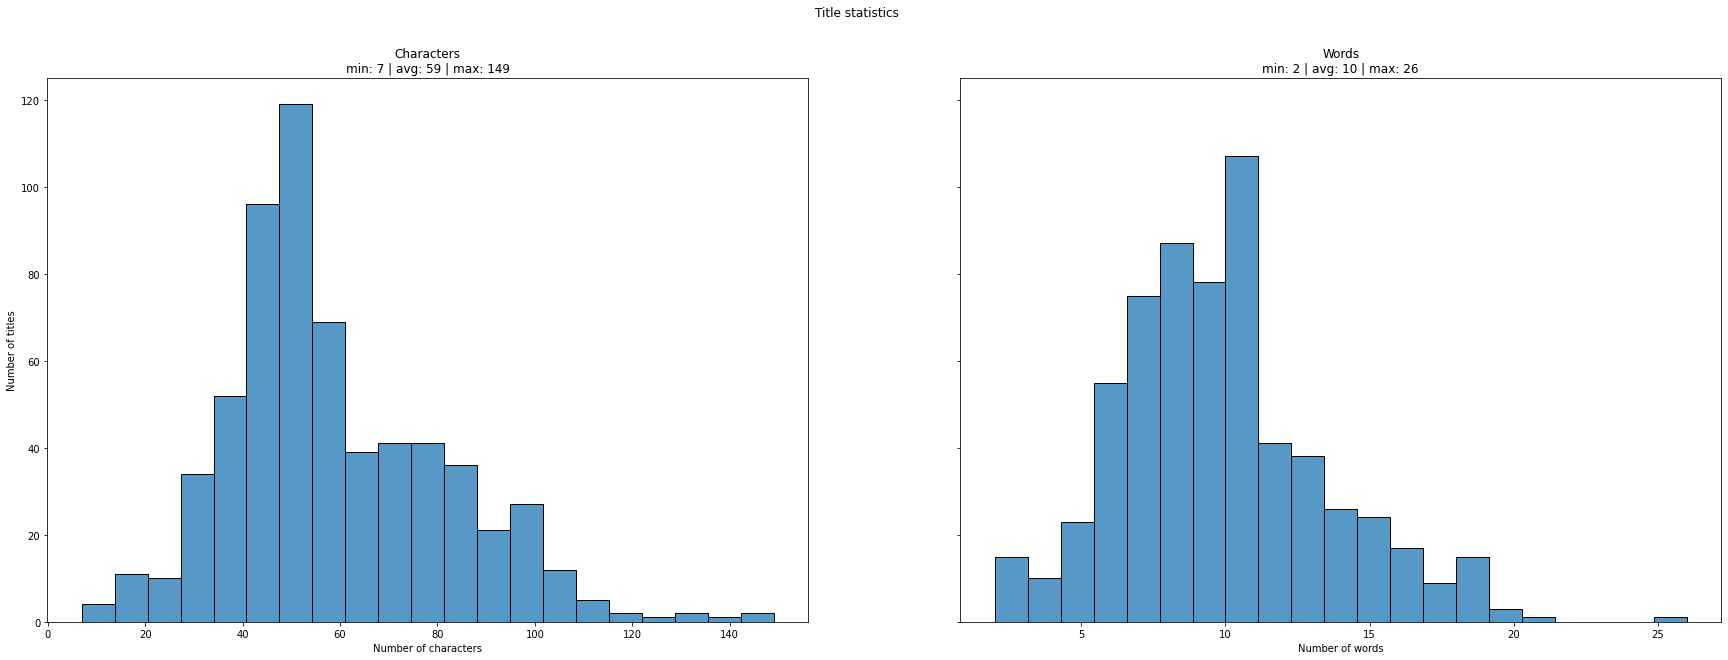

In [209]:
def show_str_statistics(data: pd.DataFrame, column: str) -> None:

    chars_num = data[column].str.len()
    words_num = data[column].apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10), sharey=True)
    fig.suptitle(f"{column.title()} statistics")
    axes = axes.flatten()

    for counts, counts_name, ax in zip([chars_num, words_num], ["characters", "words"], axes):

        title = f"{counts_name.title()}\n" \
                f"min: {counts.min()} | " \
                f"avg: {counts.mean():.0f} | " \
                f"max: {counts.max()}"
        sns.histplot(ax=ax, x=counts)
        ax.set(
            title=title,
            xlabel=f"Number of {counts_name}",
            ylabel="Number of titles",
        )

show_str_statistics(data, "title")


As we can see titles are quite short (both in characters and words metrics).

## 2.2. Url

In [63]:
data.loc[:3, "url"]

0    https://www.cnbc.com/2021/09/29/santolis-wednesday-market-notes-could-septembers-stock-shakeout-...
1    https://www.cnbc.com/2016/06/24/ian-bremmers-take-on-the-early-brexit-winners-and-losers-comment...
2                https://www.cnbc.com/2014/03/25/europes-recovery-depends-on-renzis-italycommentary.html
3             https://www.cnbc.com/2009/04/22/us-moves-closer-to-becoming-a-major-shareholder-in-gm.html
Name: url, dtype: object

Url is a string.

In [66]:
data["url"].str.startswith("https://www.cnbc.com").all()

True

All urls are from "cnbc.com" which does make sense since it's a cnbc dataset :)

## 2.3. Published_at

In [67]:
data.loc[:3, "published_at"]

0    2021-09-29T17:09:39+0000
1    2016-06-24T13:50:48-0400
2    2014-03-25T13:29:45-0400
3    2009-04-22T19:49:03+0000
Name: published_at, dtype: object

"Published_at" column contains dates in datatime format. 

Weaviate expects date format in [RFC 3339](https://weaviate.io/developers/weaviate/current/data-schema/datatypes.html#datatype-date) format. Dates in "published_at" column are in slightly different format, timezone offset should ends with time separated by colon. For example instead of current form:

In [69]:
data.loc[0, "published_at"]

'2021-09-29T17:09:39+0000'

... it should be in form:

In [81]:
data.loc[:0, "published_at"].apply(lambda x: pd.to_datetime(x).isoformat())

0    2021-09-29T17:09:39+00:00
Name: published_at, dtype: object

Otherwise data loading procedure (into Weaviate) might fail.

### 2.3.1. Dates statistics

In [187]:
published_dates = pd.to_datetime(data["published_at"], utc=True).to_frame(name="datetime")
published_dates["year"] = published_dates["datetime"].dt.year
published_dates["month"] = published_dates["datetime"].dt.month
published_dates["weekday"] = published_dates["datetime"].dt.weekday

published_dates.iloc[:3]

,datetime,year,month,weekday
0,2021-09-29 17:09:39+00:00,2021,9,2
1,2016-06-24 17:50:48+00:00,2016,6,4
2,2014-03-25 17:29:45+00:00,2014,3,1


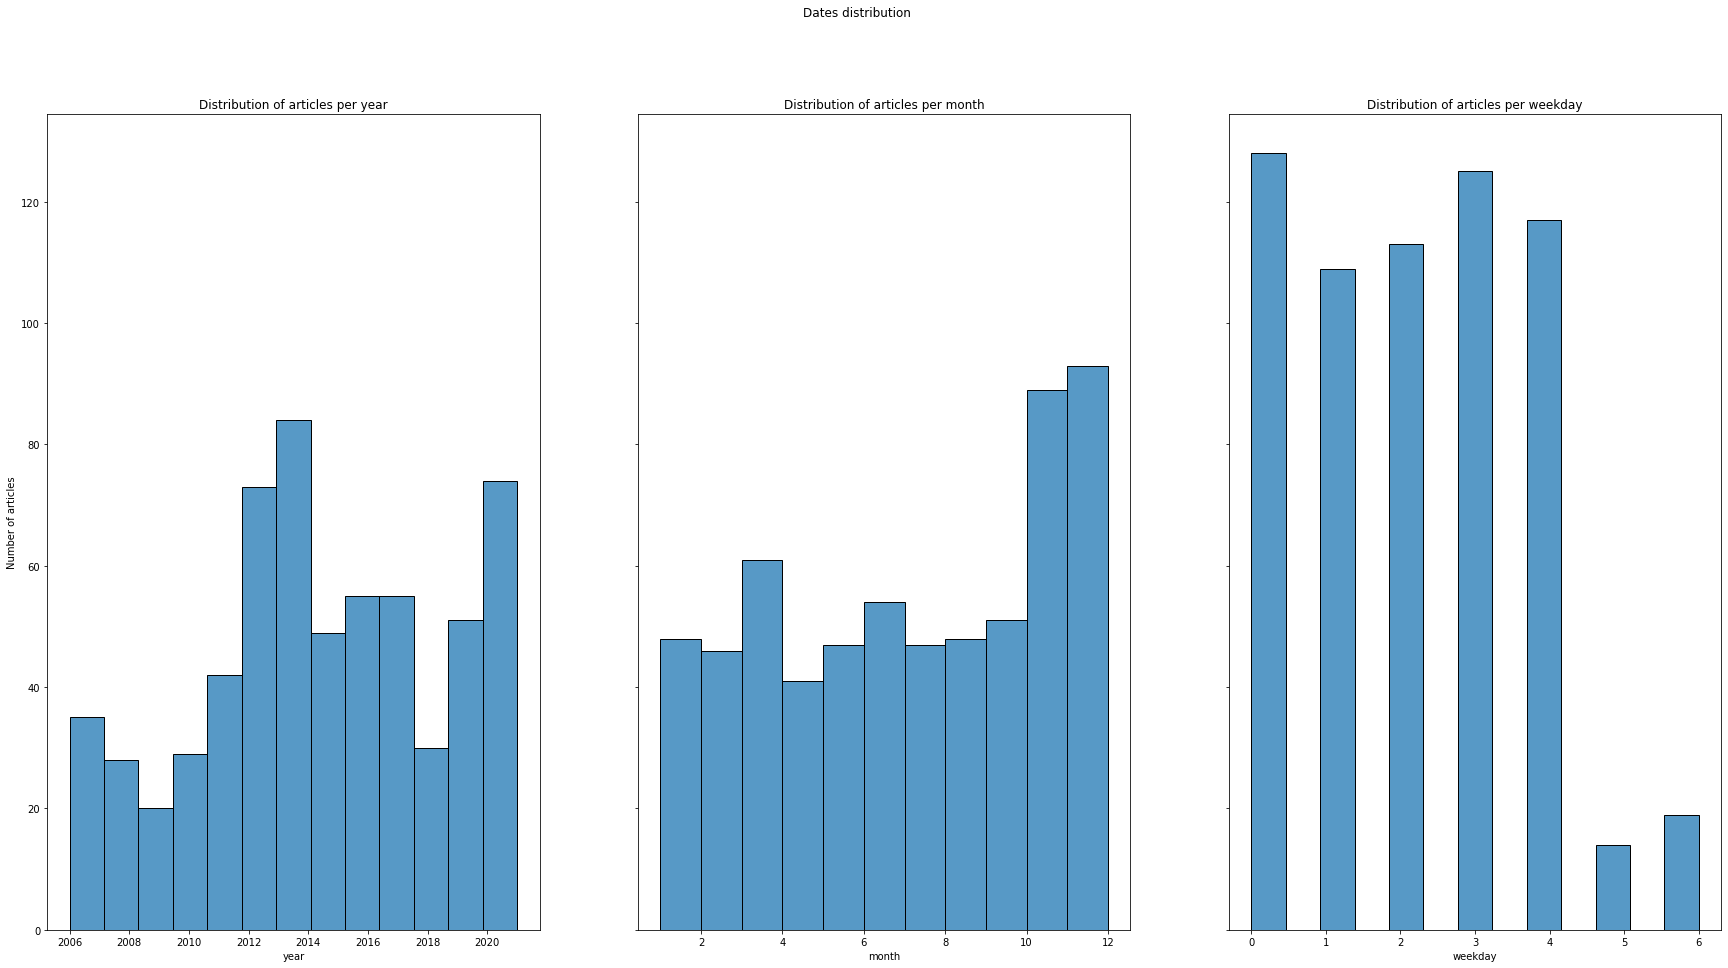

In [193]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 15), sharey=True)
fig.suptitle("Dates distribution")

for idx, column_name in enumerate(["year", "month", "weekday"]):
    sns.histplot(ax=axes[idx], x=published_dates[column_name])
    axes[idx].set(title=f"Distribution of articles per {column_name}", ylabel="Number of articles")

plt.show()

Observations:
- **year**: number of articles published per year reached it's peak in 2013
- **month**: more or less even distribution, but in november-december more articles are published (perhaps right before end of the year markets are the most active - more articles to write about)
- **weekday**: significant drop on weekend (which is expected)

## 2.4. Author

In [213]:
data.loc[14:17, "author"]

14                         NaN
15                     Tae Kim
16    Dawn Kopecki,Rich Mendez
17                         NaN
Name: author, dtype: object

Author might by either string containing author name (or multiple with comma separator) or NaN value if author is unknown. As discovered in chapter 1 around 36% of articles have missing author name.

<div class="alert alert-block alert-info"><b>Preprocessing idea</b>: in case of missing value replace it with "Unknown" token.</div>


In [241]:
keywords_count = data["author"].str.count(",")
keywords_count = keywords_count.value_counts()
keywords_count.index = keywords_count.index.map(int) + 1
keywords_count.to_frame().style.bar()

,author
1,379
2,17
3,1


As we can see the majority of all articles has only one author, 17 articles - 2 authors and only one article has 3 authors.

In [242]:
data["author"].describe()

count            397
unique           201
top       Lee Brodie
freq              24
Name: author, dtype: object

The most popular author is "Lee Brodie" which wrote 24 articles.

## 2.5. Publisher

In [244]:
data.loc[:3, "publisher"]

0    CNBC
1    CNBC
2    CNBC
3    CNBC
Name: publisher, dtype: object

In [245]:
data["publisher"].describe()

count      625
unique       1
top       CNBC
freq       625
Name: publisher, dtype: object

As expected there is only one publisher - CNBC

## 2.6. Short_description

## 2.7. Keywords

In [246]:
data.loc[:3, "keywords"]

0    cnbc, Premium, Articles, Investment strategy, Markets, Investing, PRO Home, CNBC Pro, Pro: Santo...
1    Articles, Politics, Europe News, European Central Bank, S&P 500 Index, U.S. Markets, Commentary,...
2    Articles, Business News, Economy, Europe Economy, Employment, Commentary, Politics, source:tagna...
3    cnbc, Articles, General Motors Co, Business News, Transportation, Autos, source:tagname:CNBC US ...
Name: keywords, dtype: object

Keywords is a string with list of keywords and comma separator.

In [248]:
data["keywords"].isna().sum(j)

0

There are no articles without keywords.

In [314]:
keywords_count = data["keywords"].str.count(",")
keywords_count = keywords_count.value_counts()
keywords_count.index = keywords_count.index.map(int) + 1
print(f"Min number of keywords: {keywords_count.index.min()}")
print(f"Avg number of keywords: {np.mean(keywords_count.index):.0f}")
print(f"Max number of keywords: {keywords_count.index.max()}")
keywords_count.to_frame().iloc[:10].style.bar()

Min number of keywords: 3
Avg number of keywords: 21
Max number of keywords: 60


,keywords
7,74
9,49
8,48
5,48
11,47
6,46
10,40
13,37
12,36
14,28


Minimal number of keywords is 3, maximum - 60 and on average each article contains 21 keywords.

Let's take a look a the article with the maximum number of keywords.

In [316]:
data.loc[data["keywords"].str.count(",") == keywords_count.index.max() - 1, "keywords"].values

array(['cnbc, Articles, Bank of Montreal, Wyoming, Wisconsin, West Virginia, Washington DC, Virginia, Vermont, Utah, Texas, Tennessee, South Dakota, South Carolina, Rhode Island, Pennsylvania, Oregon, Ohio, North Dakota, North Carolina, New York City, New York, New Mexico, New Jersey, New Hampshire, Nevada, Montana, Missouri, Mississippi, Minnesota, Michigan, Massachusetts, Maryland, Maine, Louisiana, Kentucky, Kansas, Iowa, Indiana, Illinois, Idaho, Hawaii, Georgia, Florida, Delaware, Connecticut, Colorado, Chicago, California, Arkansas, Arizona, Alaska, Alabama, North America, United States, Canada, Press Releases, CNBC Information and Policies, CNBC: News Releases, source:tagname:PR Newswire'],
      dtype=object)

Looks like this article contains all US states as keywords.

And here is the most popular set of keywords.

In [251]:
data["keywords"].describe()

count                                                                    625
unique                                                                   581
top       cnbc, Articles, CNBC TV, Fast Money, source:tagname:CNBC US Source
freq                                                                      10
Name: keywords, dtype: object

## 2.8. Header_image

In [317]:
data.loc[:3, "header_image"]

0        https://image.cnbcfm.com/api/v1/image/106949602-1632934577499-FINTECH_ETF_9-29.jpg?v=1632934691
1    https://fm.cnbc.com/applications/cnbc.com/resources/img/editorial/2016/06/24/103742956-RTX2FMUL....
2    https://fm.cnbc.com/applications/cnbc.com/resources/img/editorial/2014/03/24/101520523-480336057...
3                          https://image.cnbcfm.com/api/v1/image/24947979-gm_dealership.jpg?v=1354732729
Name: header_image, dtype: object

In [326]:
image_urls = data["header_image"].apply(lambda x: x.split(".com/")[0])
counter = Counter(image_urls)

counter

Counter({'https://image.cnbcfm': 471,
         'https://fm.cnbc': 12,
         'https://sc.cnbcfm': 142})

Header_image column contains links to image from article that was used as a header image. There are three different resources from which images can be loaded, but they are all related to cnbc.

## 2.9. Raw_description

## 2.10. Description

## 2.11. Scraped_at

In [327]:
data.loc[:3, "scraped_at"]

0    2021-10-30 14:11:23.709372
1    2021-10-30 14:11:23.820139
2    2021-10-30 14:11:23.854710
3    2021-10-30 14:11:24.261143
Name: scraped_at, dtype: object

In [338]:
scraped_dates = pd.to_datetime(data["scraped_at"])
scraped_dates = scraped_dates.dt.strftime("%Y-%m-%d")
scraped_dates.duplicated(keep=False).all()

True

As we can see all articles were scraped at the same date (year-month-day).